In [2]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timm
from torch.optim.lr_scheduler import LambdaLR

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

c:\Users\AMIN\anaconda3\envs\gen_music\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

### **Read dataset**

In [4]:
root_dir = 'weather-dataset/dataset'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

### **Train, val, test split**

In [5]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

### **Create pytorch dataset**

In [7]:
class WeatherDataset(Dataset):
    def __init__(self,X, y,transform=None):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

### **Create data preprocessing function**

In [8]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

### **Create dataloader**

In [9]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [10]:
train_batch_size = 256
test_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([256, 3, 224, 224])
Labels batch shape: torch.Size([256])


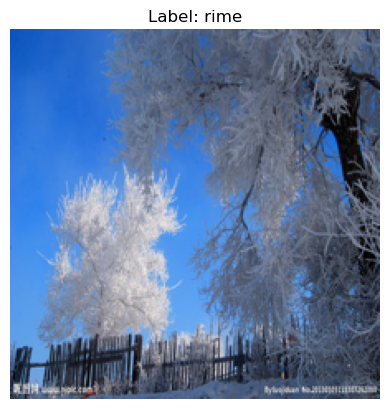

In [11]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [12]:
classes

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

### **Create model**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)
        return x

In [14]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

        self.regressor = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1)
        )

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride=1)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)

        return block_sequential


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        regressor_output = self.regressor(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x, regressor_output


In [15]:
!gdown 1DeHv1GD3qT2DgtlRVkDh01aRillGrP35

Downloading...
From (original): https://drive.google.com/uc?id=1DeHv1GD3qT2DgtlRVkDh01aRillGrP35
From (redirected): https://drive.google.com/uc?id=1DeHv1GD3qT2DgtlRVkDh01aRillGrP35&confirm=t&uuid=a06dee0c-c30a-401d-adde-b05f4d645332
To: d:\Weather Phenomena Prediction - Model Comparison\code\teacher_wt.pt

  0%|          | 0.00/85.3M [00:00<?, ?B/s]
  1%|          | 524k/85.3M [00:00<01:27, 972kB/s]
  1%|          | 1.05M/85.3M [00:00<01:09, 1.21MB/s]
  2%|▏         | 1.57M/85.3M [00:01<01:03, 1.32MB/s]
  2%|▏         | 2.10M/85.3M [00:01<00:58, 1.43MB/s]
  3%|▎         | 2.62M/85.3M [00:01<00:59, 1.40MB/s]
  4%|▎         | 3.15M/85.3M [00:02<00:57, 1.42MB/s]
  4%|▍         | 3.67M/85.3M [00:02<00:58, 1.40MB/s]
  5%|▍         | 4.19M/85.3M [00:03<01:00, 1.35MB/s]
  6%|▌         | 4.72M/85.3M [00:03<00:50, 1.60MB/s]
  6%|▌         | 5.24M/85.3M [00:03<00:45, 1.75MB/s]
  7%|▋         | 5.77M/85.3M [00:03<00:44, 1.78MB/s]
  7%|▋         | 6.29M/85.3M [00:04<00:38, 2.05MB/s]
  8%|▊        

In [18]:
class ModifiedPretrainedResNet(nn.Module):
    def __init__(self, original_model):
        super(ModifiedPretrainedResNet, self).__init__()
        self.features = nn.Sequential(
            *list(original_model.children())[:-2]
        )
        self.avgpool = original_model.global_pool
        self.fc = original_model.get_classifier()

    def forward(self, x):
        conv_feature_map = self.features(x)

        x = self.avgpool(conv_feature_map)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x, conv_feature_map

In [19]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

teacher_model = timm.create_model(
    'resnet34', 
    pretrained=True, 
    num_classes=n_classes
).to(device)

teacher_model = ModifiedPretrainedResNet(teacher_model)

student_model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2], 
    n_classes=n_classes
).to(device)

In [20]:
teacher_model.eval()
student_model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    teacher_output = teacher_model(dummy_tensor)
    student_output = student_model(dummy_tensor) 

print('Teacher output shape: ', teacher_output[0].shape, teacher_output[1].shape)
print('Student output shape: ', student_output[0].shape, student_output[1].shape) 

Teacher output shape:  torch.Size([1, 11]) torch.Size([1, 512, 7, 7])
Student output shape:  torch.Size([1, 11]) torch.Size([1, 512, 7, 7])


### **Training**

In [21]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [22]:
def fit(
    teacher,
    student,
    feature_map_weight,
    ce_loss_weight,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []
    val_accs = []
    teacher.eval()

    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        batch_train_losses = []

        student.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)
            student_logits, regressor_feature_map = student(inputs)

            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)
            label_loss = criterion(student_logits, labels)

            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            student, val_loader,
            criterion, device
        )
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        scheduler.step()

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc:.4f}')

    return train_losses, val_losses, val_accs

In [23]:
lr = 1e-2
epochs = 30

def lr_lambda(epoch, warmup_epochs=5, total_epochs=30, init_scale=0.1, min_scale=0.3):
    scale_range = 1.0 - min_scale

    if epoch < warmup_epochs:
        warmup_factor = epoch / warmup_epochs
        return init_scale + (1.0 - init_scale) * warmup_factor

    decay_factor = (total_epochs - epoch) / (total_epochs - warmup_epochs)
    return min_scale + scale_range * max(0.0, decay_factor)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    student_model.parameters(),
    lr=lr
)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [24]:
for epoch in range(epochs):
    print(f'Epoch {epoch}, LR: {lr * lr_lambda(epoch):.6f}')

Epoch 0, LR: 0.001000
Epoch 1, LR: 0.002800
Epoch 2, LR: 0.004600
Epoch 3, LR: 0.006400
Epoch 4, LR: 0.008200
Epoch 5, LR: 0.010000
Epoch 6, LR: 0.009720
Epoch 7, LR: 0.009440
Epoch 8, LR: 0.009160
Epoch 9, LR: 0.008880
Epoch 10, LR: 0.008600
Epoch 11, LR: 0.008320
Epoch 12, LR: 0.008040
Epoch 13, LR: 0.007760
Epoch 14, LR: 0.007480
Epoch 15, LR: 0.007200
Epoch 16, LR: 0.006920
Epoch 17, LR: 0.006640
Epoch 18, LR: 0.006360
Epoch 19, LR: 0.006080
Epoch 20, LR: 0.005800
Epoch 21, LR: 0.005520
Epoch 22, LR: 0.005240
Epoch 23, LR: 0.004960
Epoch 24, LR: 0.004680
Epoch 25, LR: 0.004400
Epoch 26, LR: 0.004120
Epoch 27, LR: 0.003840
Epoch 28, LR: 0.003560
Epoch 29, LR: 0.003280


In [25]:
train_losses, val_losses, val_accs = fit(
    teacher_model,
    student_model,
    0.25,
    0.75,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 2.0043	Val loss: 2.4005	Val acc: 0.1122
EPOCH 2:	Train loss: 1.6554	Val loss: 2.1011	Val acc: 0.2833
EPOCH 3:	Train loss: 1.3772	Val loss: 1.5575	Val acc: 0.4924
EPOCH 4:	Train loss: 1.1956	Val loss: 1.3042	Val acc: 0.5492
EPOCH 5:	Train loss: 1.0688	Val loss: 1.1823	Val acc: 0.6103
EPOCH 6:	Train loss: 0.9976	Val loss: 1.2736	Val acc: 0.5732
EPOCH 7:	Train loss: 0.9296	Val loss: 1.1065	Val acc: 0.6286
EPOCH 8:	Train loss: 0.8791	Val loss: 1.6241	Val acc: 0.4807
EPOCH 9:	Train loss: 0.8385	Val loss: 1.1081	Val acc: 0.6358
EPOCH 10:	Train loss: 0.7875	Val loss: 1.0252	Val acc: 0.6679
EPOCH 11:	Train loss: 0.7573	Val loss: 1.1729	Val acc: 0.6198
EPOCH 12:	Train loss: 0.7310	Val loss: 1.2600	Val acc: 0.5717
EPOCH 13:	Train loss: 0.7055	Val loss: 0.9379	Val acc: 0.7007
EPOCH 14:	Train loss: 0.6640	Val loss: 0.9752	Val acc: 0.6905
EPOCH 15:	Train loss: 0.6430	Val loss: 0.9967	Val acc: 0.6759
EPOCH 16:	Train loss: 0.6153	Val loss: 0.9950	Val acc: 0.6817
EPOCH 17:	Train l

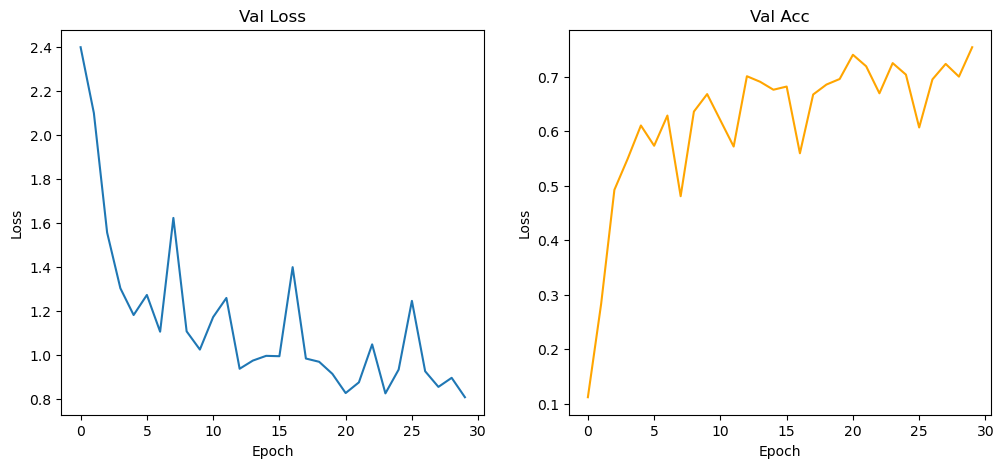

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(val_losses)
ax[0].set_title('Val Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_accs, color='orange')
ax[1].set_title('Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

### **Evaluation**

In [27]:
val_loss, val_acc = evaluate(
    student_model, 
    val_loader, 
    criterion, 
    device
)

test_loss, test_acc = evaluate(
    student_model, 
    test_loader,
    criterion, 
    device 
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.7538237436270939
Test accuracy:  0.74235807860262


### **Save model**

In [28]:
save_path = 'interreg_pretrained_wt.pt'
torch.save(student_model.state_dict(), save_path)